In [33]:
import torch
from torch import nn, einsum, Tensor
from einops import rearrange, repeat
import torch.nn.functional as F

In [34]:
def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def exists(val):
    return val is not None


In [35]:
class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.register_buffer("beta", torch.zeros(dim))

    def forward(self, x):
        return F.layer_norm(x, x.shape[-1:], self.gamma, self.beta)


In [36]:
class Attention(nn.Module):
    def __init__(
            self,
            dim,
            dim_head=64,
            heads=8
    ):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.norm = LayerNorm(dim)

        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)

    def forward(
            self,
            x,
            context=None,
            attn_mask=None,
            key_padding_mask=None,
    ):
        x = self.norm(x)
        kv_x = default(context, x)

        q, k, v = (self.to_q(x), *self.to_kv(kv_x).chunk(2, dim=-1))

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), (q, k, v))

        q = q * self.scale
        sim = einsum('b h i d, b h j d -> b h i j', q, k)

        if exists(attn_mask):
            sim = sim.masked_fill(attn_mask, -torch.finfo(sim.dtype).max)
        if exists(key_padding_mask):
            key_padding_mask = repeat(key_padding_mask, "b i -> b h j i", h=self.heads, j=sim.shape[-2])
            sim = sim.masked_fill(key_padding_mask, -torch.finfo(sim.dtype).max)

        attn = sim.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

tensor([0., 0., 1., 1., 2., 2., 3., 3.])


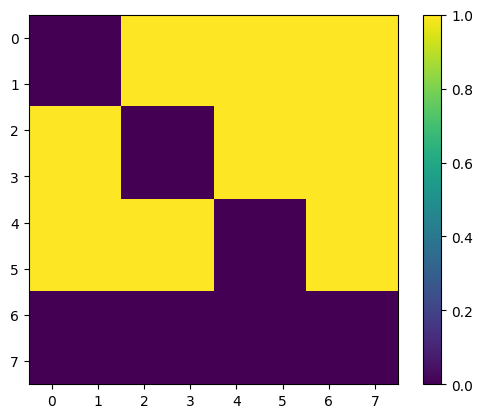

In [37]:
import matplotlib.pyplot as plt
from einops import rearrange
token_types = torch.cat([torch.ones(2)*i for i in range(4)])
print(token_types)
def create_zorro_mask(token_types, fusion_token):
    token_types_attend_from = rearrange(token_types, 'i -> i 1')
    token_types_attend_to = rearrange(token_types, 'j -> 1 j')
    zorro_mask = token_types_attend_from == token_types_attend_to
    zorro_mask = zorro_mask | (token_types_attend_from == fusion_token)
    zorro_mask = zorro_mask #| torch.eye(token_types.shape[0],token_types.shape[0]).to(torch.bool)
    #zorro_mask = repeat(zorro_mask, 'j i -> i j')
    return ~zorro_mask #.to(torch.long)
#plt.imshow(create_zorro_mask(token_types, 3))
zorro_mask = create_zorro_mask(token_types, 3)
#zorro_mask[4:,4:6]=1
zorro_mask=zorro_mask & ~torch.eye(token_types.shape[0],token_types.shape[0]).to(torch.bool)
plt.imshow(zorro_mask)
plt.colorbar()

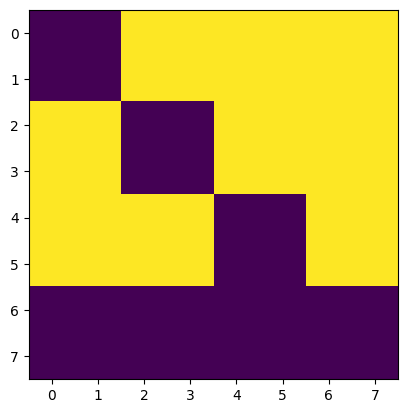

In [38]:
padding_mask = torch.cat([torch.zeros(2),
                          torch.zeros(2), 
                          torch.ones(2), 
                          torch.zeros(2)]).to(torch.bool)#.unsqueeze(0)
padding_mask2 = torch.cat([torch.zeros(2),
                          torch.ones(2), 
                          torch.zeros(2), 
                          torch.zeros(2)]).to(torch.bool)#.unsqueeze(0)
padding_mask = torch.stack([padding_mask, padding_mask2])
p=padding_mask.unsqueeze(1).repeat(1,8,1)
z=zorro_mask #zorro_mask.unsqueeze(0).repeat(2,1,1)
#x = (z | p) & ~torch.eye(padding_mask.shape[1],padding_mask.shape[1]).to(torch.bool)
#x = torch.repeat_interleave(x, 2, dim=0)
x = z
plt.imshow(x[:,:])

In [39]:
attn=Attention(2,2,2)
print(padding_mask.shape)

torch.Size([2, 8])


In [40]:
batch=torch.randn(2,8,2)
attn(batch, batch, attn_mask=zorro_mask,key_padding_mask=padding_mask)

tensor([[[ 0.1967, -0.0951],
         [ 0.1967, -0.0951],
         [-0.1638,  0.1844],
         [-0.2048,  0.1818],
         [-0.0718,  0.0141],
         [-0.0718,  0.0141],
         [-0.0367, -0.0233],
         [-0.0367, -0.0233]],

        [[-0.1071,  0.1041],
         [-0.0399, -0.0167],
         [-0.0346,  0.0139],
         [-0.0346,  0.0139],
         [ 0.1780, -0.0533],
         [-0.0390, -0.0373],
         [ 0.0337, -0.0191],
         [-0.0600,  0.0424]]], grad_fn=<UnsafeViewBackward0>)